In [1]:
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
from eval_methods import *

2023-05-19 08:30:38.552646: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
import gdown
import zipfile

# Cohort level preprocessed data
url_cohort = 'https://drive.google.com/uc?id=1u1bYdXnffUfAM4UeAJIRoH_6Q7C6n0xQ'

output_cohort = '/content/cohort.zip'
gdown.download(url_cohort, output_cohort, quiet=False)

with zipfile.ZipFile('/content/cohort.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

url_model = 'https://drive.google.com/file/d/1x6-q9UST8t3_Y-f27dtodGRdM-MQRCEr/view?usp=share_link'

model_files = '/content/models.zip'
gdown.download(url_model, model_files, quiet=False)

with zipfile.ZipFile('/content/models.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/models')

In [3]:
data_dir = '/content/data/content/data/aug/'
model_path = '/content/models/'
size = 224
input_dim = (size, size, 1)
batch_size = 16

In [5]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator()

datagen = image_generator.flow_from_directory(
        data_dir,
        target_size=(size, size),
        batch_size=1,
        color_mode='grayscale',
        class_mode=None,
        shuffle=False)

Found 29910 images belonging to 30 classes.


In [6]:
# get all the images from the generator and save them to a numpy array
train_images = []
train_labels = []
for i in tqdm(range(len(datagen))):
    image = datagen[i]
    image = image.flatten()
    image = image.reshape((size, size, 1))
    train_images.append(image)

# for each image in the generator, split the class label into two separate labels using - as a seperator and add them to the generator
age_labels = []
gender_labels = []
for i in range(len(datagen.filenames)):
    train_labels.append(datagen.filenames[i])
    datagen.filenames[i] = datagen.filenames[i].split('-')
    datagen.filenames[i][0] = int(datagen.filenames[i][0])
    datagen.filenames[i][1] = int(datagen.filenames[i][1].split('/')[0])
    age_labels.append(datagen.filenames[i][0])
    gender_labels.append(datagen.filenames[i][1])

100%|██████████| 29910/29910 [03:12<00:00, 155.45it/s]


In [7]:
# convert the labels to numpy arrays and combine them with the images
age_labels = np.array(age_labels)
gender_labels = np.array(gender_labels)
train_images = np.array(train_images)
train_labels = np.array(train_labels)


# binarize the labels
gender_lb = LabelBinarizer()
gender_labels = gender_lb.fit_transform(gender_labels)

age_lb = LabelBinarizer()
age_labels = age_lb.fit_transform(age_labels)

X_train, X_val, y_train_age, y_val_age, y_train_gender, y_val_gender = train_test_split(train_images, age_labels, gender_labels, test_size=0.2, random_state=42)

In [9]:
model = tf.keras.models.load_model(model_path + 'dual_model.h5')

In [10]:
# get the predictions for age
y_pred = model.predict(X_val)

2023-05-18 12:32:44.956526: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-18 12:32:44.956766: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 4199690000 Hz
2023-05-18 12:32:45.040006: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-18 12:32:45.163738: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-05-18 12:32:47.112530: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-18 12:32:47.112562: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Garbage collection: deallocate free memory regions (i.e

In [11]:
model.evaluate(X_val, {'age': y_val_age, 'gender': y_val_gender})

187/187 [==============================] - 14s 69ms/step - loss: 3.1769 - age_loss: 3.1155 - gender_loss: 0.5548 - age_accuracy: 0.1417 - age_top_k_categorical_accuracy: 0.6386 - age_precision: 0.2295 - age_recall: 0.0096 - age_auc: 0.7044 - gender_accuracy: 0.7180 - gender_top_k_categorical_accuracy: 1.0000 - gender_precision: 0.9490 - gender_recall: 0.5313 - gender_auc: 0.9276


[3.195868492126465,
 3.1345067024230957,
 0.566414475440979,
 0.14159144461154938,
 0.6303911805152893,
 0.203125,
 0.008692745119333267,
 0.7015820741653442,
 0.7166499495506287,
 1.0,
 0.9477806687355042,
 0.5322580933570862,
 0.9251278638839722]

In [12]:
from sklearn.metrics import classification_report
# get the class names from the unique labels in y_val_age
class_names = np.unique(np.argmax(y_val_age, axis=1))

# get the true labels
y_pred_age = np.argmax(y_pred[0], axis=1)
y_true_age = np.argmax(y_val_age, axis=1)

y_true_gender = y_val_gender
y_pred_gender = y_pred[1]
# if the value in y_pred_gender is equal or bigger than 0.5 make it one else make it zero

for i in range(len(y_pred_gender)):
    if y_pred_gender[i] >= 0.4:
        y_pred_gender[i] = 1
    else:
        y_pred_gender[i] = 0

# if the value in y_pred_gener is equal or bigger than 0.5 make it one else make it zero


# get the classification report
report_age = classification_report(y_true_age, y_pred_age, target_names=class_names, output_dict=True)
report_age = pd.DataFrame(report_age).transpose()

report_gender = classification_report(y_true_gender, y_pred_gender, target_names=None, output_dict=True)
report_gender = pd.DataFrame(report_gender).transpose()

/home/jupyter/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [13]:
# get precision, accuracy, recall and f1 score for the gender predictions
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
print(precision_score(y_true_gender, y_pred_gender, average='weighted'))
print(accuracy_score(y_true_gender, y_pred_gender, normalize=True))
print(recall_score(y_true_gender, y_pred_gender, average='weighted'))
print(f1_score(y_true_gender, y_pred_gender, average='weighted'))

0.8167731066531881
0.7619525242393849
0.7619525242393849
0.7595591742192119


In [14]:
# get precision, accuracy, recall and f1 score for the gender predictions
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
print(precision_score(y_true_age, y_pred_age, average='weighted'))
print(accuracy_score(y_true_age, y_pred_age, normalize=True))
print(recall_score(y_true_age, y_pred_age, average='weighted'))
print(f1_score(y_true_age, y_pred_age, average='weighted'))

0.17340635498044082
0.14159144098963558
0.14159144098963558
0.11789434798796375


/home/jupyter/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# combine the age and gender predictions into one dataframe
y_pred_combined = pd.DataFrame(y_pred_age, columns=['age'])
y_pred_combined['gender'] = y_pred_gender
y_pred_combined['combined'] = ''

# combine the age and gender columns using - as a seperator in a new column called prediction
for i in range(len(y_pred_combined)):
    y_pred_combined['combined'][i] = str(y_pred_combined['age'][i]) + '-' + str(int(y_pred_combined['gender'][i]))

# do the same for the true labels
y_true_combined = pd.DataFrame(y_true_age, columns=['age'])
y_true_combined['gender'] = y_true_gender
y_true_combined['combined'] = ''

for i in range(len(y_true_combined)):
    y_true_combined['combined'][i] = str(y_true_combined['age'][i]) + '-' + str(int(y_true_combined['gender'][i]))
    
# convert the combined columns to classes from 0 to 29
#y_pred_combined['combined'] = y_pred_combined['combined'].astype('category')
#y_pred_combined['combined'] = y_pred_combined['combined'].cat.codes

#y_true_combined['combined'] = y_true_combined['combined'].astype('category')
#y_true_combined['combined'] = y_true_combined['combined'].cat.codes


/tmp/ipykernel_10894/3408600726.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_pred_combined['combined'][i] = str(y_pred_combined['age'][i]) + '-' + str(int(y_pred_combined['gender'][i]))
/tmp/ipykernel_10894/3408600726.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_true_combined['combined'][i] = str(y_true_combined['age'][i]) + '-' + str(int(y_true_combined['gender'][i]))


In [16]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
print(precision_score(y_true_combined['combined'], y_pred_combined['combined'], average='weighted'))
print(accuracy_score(y_true_combined['combined'], y_pred_combined['combined'], normalize=True))
print(recall_score(y_true_combined['combined'], y_pred_combined['combined'], average='weighted'))
print(f1_score(y_true_combined['combined'], y_pred_combined['combined'], average='weighted'))

0.15094871675925023
0.10648612504179204
0.10648612504179204
0.09295186635713472


/home/jupyter/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


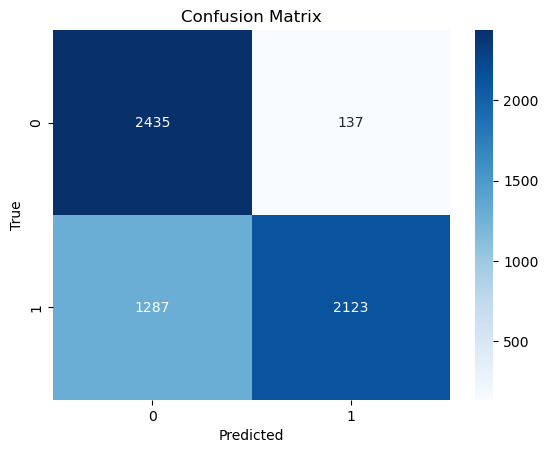

In [17]:
# age
confusion_matrix_show(y_true_combined['gender'], y_pred_combined['gender'])

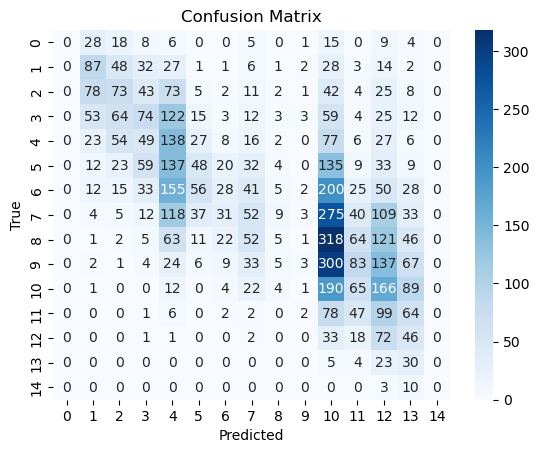

In [18]:
# sort the true age labels in ascending order
confusion_matrix_show(y_true_combined['age'], y_pred_combined['age'])

/dmc/Study_Data/1_Master/6_Machine_Learning/Final_Project/eval_methods.py:39: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = point_frequency.pivot('Predicted', 'True', 'Frequency')


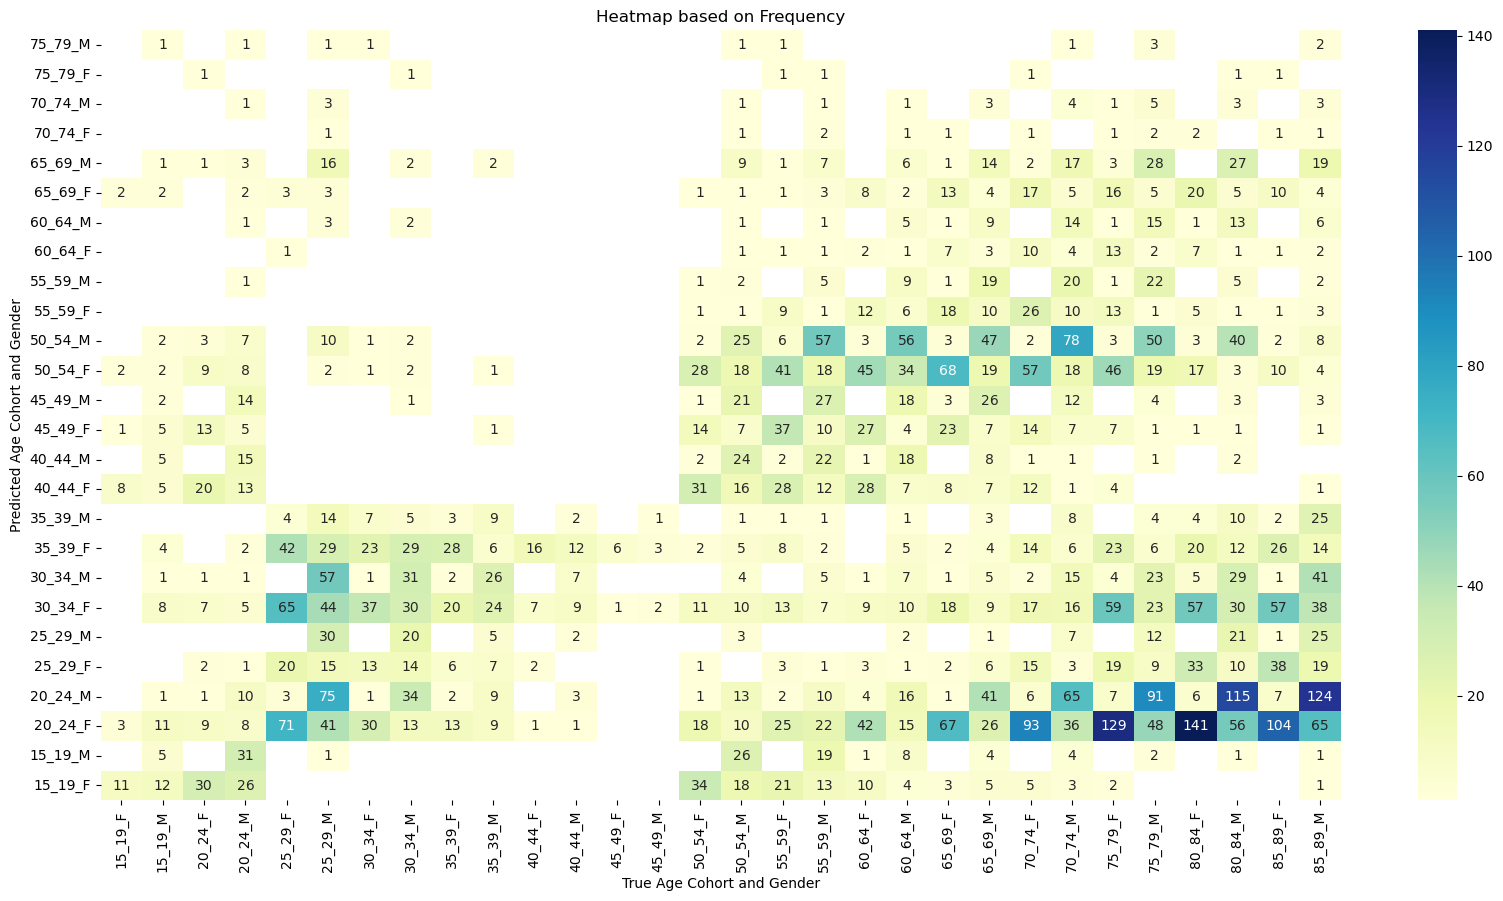

In [19]:
y_pred_combined['combined'] = y_pred_combined['combined'].astype('category')
y_pred_combined['combined'] = y_pred_combined['combined'].cat.codes

y_true_combined['combined'] = y_true_combined['combined'].astype('category')
y_true_combined['combined'] = y_true_combined['combined'].cat.codes

heat_df = pd.DataFrame({'True': y_true_combined['combined'], 'Predicted': y_pred_combined['combined']})
heat_df = mapping_tool(heat_df)
graph_heat(heat_df)

In [20]:
# create a classification report based on the combiend predictions and the train labels
report_combined = classification_report(y_true_combined['combined'], y_pred_combined['combined'], target_names=None, output_dict=True)
report_combined = pd.DataFrame(report_combined).transpose()

/home/jupyter/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [5]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator()

datagen = image_generator.flow_from_directory(
        data_dir,
        target_size=(size, size),
        batch_size=1,
        color_mode='grayscale',
        class_mode='categorical',
        shuffle=True)

# split the data into training and validation sets
X = []
y = []
for image_batch, label_batch in tqdm(datagen):
    image = image_batch.flatten()
    image = image.reshape(size, size, 1)
    X.append(image)
    label = label_batch.flatten()
    y.append(label)
    if len(X) == len(datagen):
        break

X = np.array(X)
y = np.array(y)

Found 29910 images belonging to 30 classes.


100%|█████████▉| 29909/29910 [03:13<00:00, 154.74it/s]


In [6]:
single_model = tf.keras.models.load_model(model_path + 'single_mode.h5')

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
y_pred = single_model.predict(X_val)

2023-05-18 12:40:47.481629: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-18 12:40:47.481867: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 4199690000 Hz
2023-05-18 12:40:47.555164: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-18 12:40:47.654005: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-05-18 12:40:49.534011: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-18 12:40:49.534047: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Garbage collection: deallocate free memory regions (i.e

In [9]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
# convert y_pred to classes
y_pred_max = np.argmax(y_pred, axis=1)
y_val_max = np.argmax(y_val, axis=1)
print(precision_score(y_val_max, y_pred_max, average='weighted'))
print(accuracy_score(y_val_max, y_pred_max, normalize=True))
print(recall_score(y_val_max, y_pred_max, average='weighted'))
print(f1_score(y_val_max, y_pred_max, average='weighted'))

0.15993986560991053
0.12988966900702106
0.12988966900702106
0.12735550925436642


In [10]:
# create teh classification report
from sklearn.metrics import classification_report
report_combined = classification_report(y_val_max, y_pred_max, target_names=None, output_dict=True)
report_combined = pd.DataFrame(report_combined).transpose()

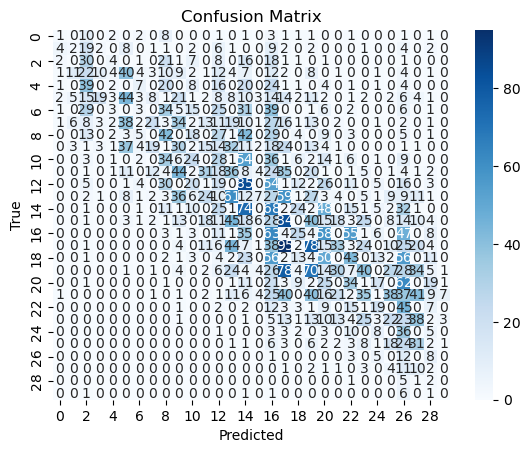

In [11]:
confusion_matrix_show(y_val_max, y_pred_max)

/dmc/Study_Data/1_Master/6_Machine_Learning/Final_Project/eval_methods.py:39: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = point_frequency.pivot('Predicted', 'True', 'Frequency')


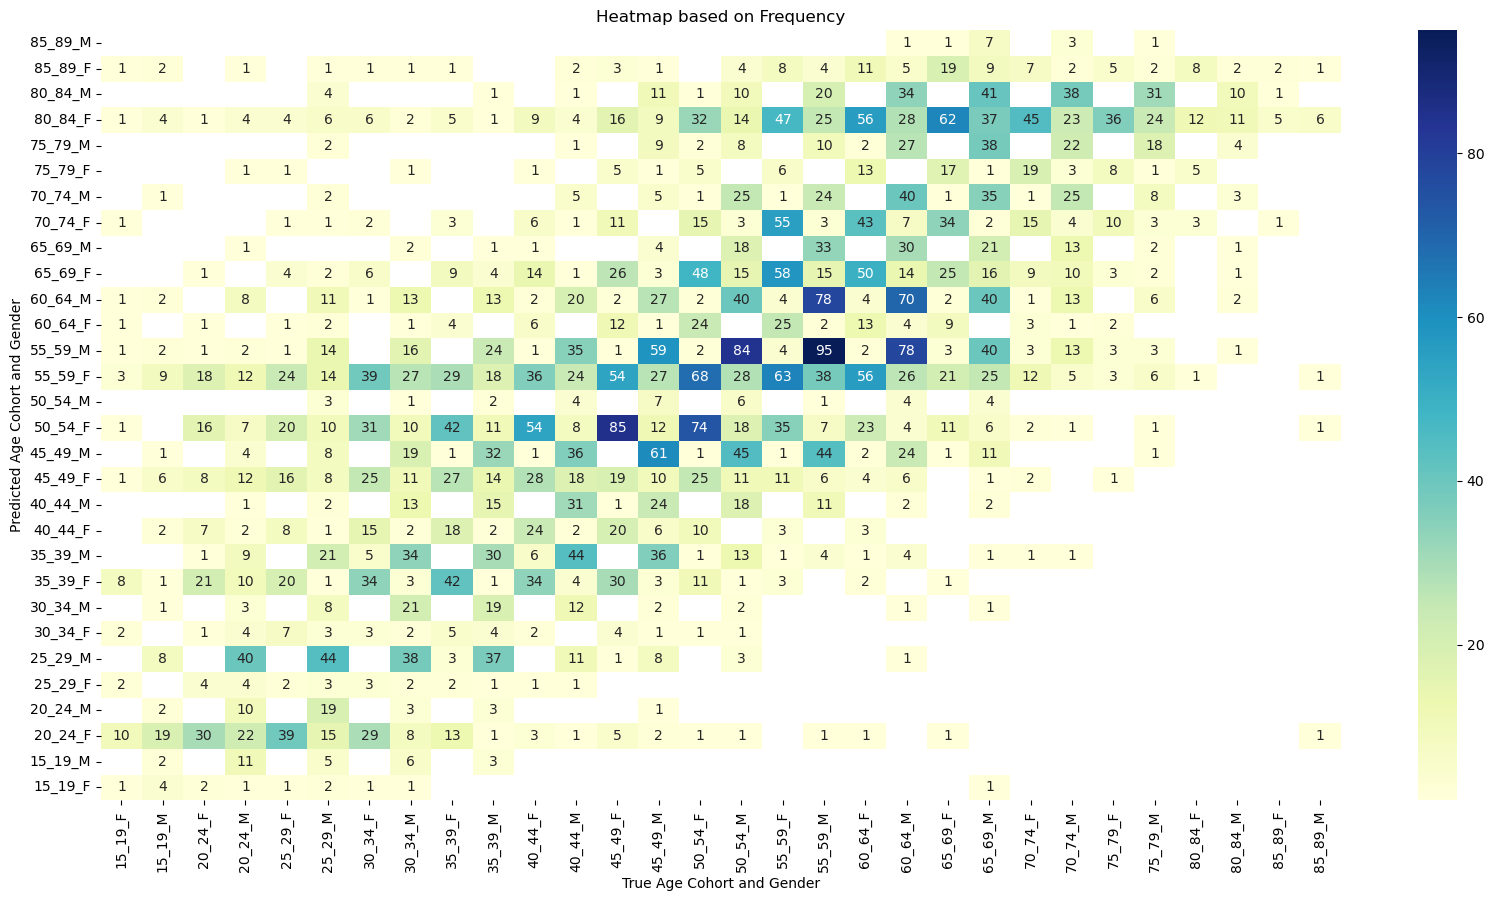

In [12]:
heat_df = pd.DataFrame({'True': y_val_max, 'Predicted': y_pred_max})
heat_df = mapping_tool(heat_df)
graph_heat(heat_df)

In [13]:
# split the labels to just contain the gender using the head_df data and only keeping the last character
for i in range(len(heat_df)):
    heat_df['True'][i] = str(heat_df['True'][i])[-1]
    heat_df['Predicted'][i] = str(heat_df['Predicted'][i])[-1]

# convert the labels to integers with 0 for F and 1 for M
heat_df['True'] = heat_df['True'].astype('category')
heat_df['True'] = heat_df['True'].cat.codes

heat_df['Predicted'] = heat_df['Predicted'].astype('category')
heat_df['Predicted'] = heat_df['Predicted'].cat.codes


In [14]:
print(precision_score(heat_df['True'], heat_df['Predicted'], average='weighted'))
print(accuracy_score(heat_df['True'], heat_df['Predicted'], normalize=True))
print(recall_score(heat_df['True'], heat_df['Predicted'], average='weighted'))
print(f1_score(heat_df['True'], heat_df['Predicted'], average='weighted'))

0.8611414520797698
0.8248077566031428
0.8248077566031428
0.8243912337109027


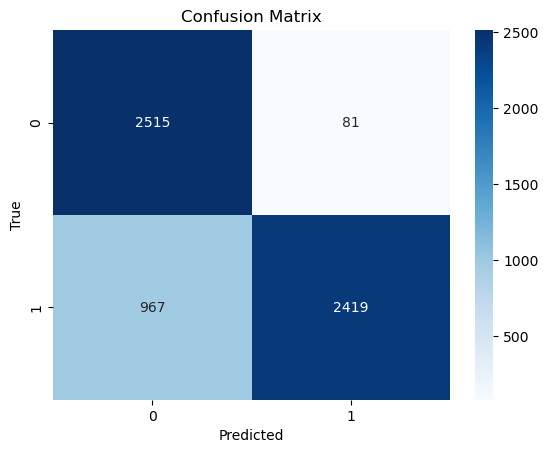

In [15]:
confusion_matrix_show(heat_df['True'], heat_df['Predicted'])

In [ ]:
# read in dual_model_history.csv and produce a graph of the training and validation accuracy and loss
dual_model_history = pd.read_csv('history_dual_model_2.csv')
# transpose the dataframe
dual_model_history = dual_model_history.T

# rename the columns to loss and val_loss inplace
dual_model_history.rename(columns={0: 'loss', 1: 'val_loss'}, inplace=True)

In [ ]:
# plot the loss and val_loss in a line graph using blue and grey lines
dual_model_history.plot.line(y=['loss', 'val_loss'], color=['blue', 'grey'])
plt.title('Dual Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')